# *Challenge \#2*: An empirical study on the learnability of functions by *NNs*

## Annalisa Paladino

Advanced Topics in Machine Learning -- Fall 2024, UniTS

In the following *challenge exercises*, we will empirically investigate the behaviour of deep neural networks with respect to the learning of specific classes of functions, and in specific training regimes.

### A. The effect of *under-* and *over-* parameterisation in the *Teacher/Student* setup

In this exercise, we will train deep neural networks (*students*), supervisedly, on input/output pairs produced by another deep neural network with frozen weights (*teacher*).[^1] Given our ability to modulate the expressivity of both networks, this setup allows us to disentangle the effects of task hardness, model expressivity, and training dynamics.

We will monitor the training and test loss of the *students* during training, as well as the final distribution of weights. We will do so in three regimes: when the *student* has much less (*under-parameterisation*), much more (*over-parameterisation*) or exactly the same learnable parameters (within a fixed given structure) as those frozen in the *teacher*.

#### What to do?

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.optim import Adam
import numpy as np
import random
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

SEED = 3407
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


1.   Instantiate the *teacher* model $\mathcal{T}$, a fully-connected feedforward neural network mapping a $100$-dimensional input to a single output scalar. Use  $3$ hidden layers of sizes, respectively: $75$, $50$, $10$. Use the $\mathsf{ReLU}$ activation function after all neurons, except for the output. Weights and biases should be initialised as *i.i.d.* samples from the Standard Normal distribution. Keep those parameters fixed for the rest of the exercise.

In [67]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=100, hidden_layers=[75, 50, 10], output_size=1):
        super().__init__()
        layers = []
        prev = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, output_size))
        self.model = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=1.0)
                nn.init.normal_(m.bias, mean=0.0, std=1.0)

    def forward(self, x):
        return self.model(x)

In [68]:
teacher = FullyConnectedNN().to(DEVICE)
teacher.eval()

FullyConnectedNN(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=75, bias=True)
    (1): ReLU()
    (2): Linear(in_features=75, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

2.   Generate the **test set** for the learning task, by repeatedly querying the *teacher* model. Inputs $\boldsymbol{x}_i \in \mathbb{R}^{100}$ should be obtained as samples from the multivariate Uniform distribution in the interval $[0,2]^{100}$, whereas the outputs as $y_i = \mathcal{T}(\boldsymbol{x}_i)$. Generate at least $6 \times 10^4$ datapoints and keep them fixed for the rest of the exercise. Such points will be used as a way to quantify generalisation error by the *student* model.

In [69]:
N_TEST = int(6e4)
X_test = 2 * torch.rand(N_TEST, 100)
y_test = teacher(X_test.to(DEVICE)).detach().cpu().flatten()
test_data = TensorDataset(X_test, y_test)

3.   Instantiate the *student* model $\mathcal{S}$, a fully-connected feedforward neural network mapping a $100$-dimensional input to a single output scalar – as in the case of the teacher. Repeat the steps that follow with (at least) three different *student* models, architecturally identical to the *teacher* but with different number and width of the hidden layers.
     -   $S_u$: one hidden layer of size $10$;
     -   $S_e$: as for the *teacher*;
     -   $S_o$: $4$ hidden layers of sizes $200$, $200$, $200$, $100$;

In [70]:
student_configs = {
    "student_u": [10],
    "student_e": [75, 50, 10],
    "student_o": [200, 200, 200, 100],
}

def get_student(name):
    return FullyConnectedNN(hidden_layers=student_configs[name]).to(DEVICE)

4.   Train the *student* model on the *MSE* loss for a sufficiently large number of iterations, as to allow for the training and test loss to reach a quasi-stationary behaviour. To actually perform the training, harvest a fresh sample of $\mathsf{B}$ inputs (*i.e.* $\left\{{\boldsymbol{x}_1, \dots, \boldsymbol{x}_{\mathsf{B}}}\right\}$) per iteration, label each of them using the *teacher* model, and train the *student* on the given batch. Use an optimizer of your choice, taking care to tune (at least) its learning rate to minimize time to convergence. Do not use default learning rates assuming they are already optimal! Do not optimize batch-size (as it is scarcely effective when tuning also the learning rate[^2]): you can use $\mathsf{B}=128$ (or less, if you cannot make it fit into memory).
     As the training progresses, log the training loss (every batch, if you can). Additionally, log also the test-set loss every given number of batches (of your choice).

In [71]:
def train_student(student, teacher, test_data, lr, epochs=1000, batch_size=128):
    teacher = teacher.to(DEVICE)
    student = student.to(DEVICE)
    loss_fn = nn.MSELoss()
    optimizer = Adam(student.parameters(), lr=lr)

    train_losses, test_losses = [], []

    X_test, y_test = test_data[:]
    X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

    for epoch in trange(epochs, leave=False):
        student.train()
        X_batch = 2 * torch.rand(batch_size, 100).to(DEVICE)
        y_batch = teacher(X_batch).detach().flatten()

        optimizer.zero_grad()
        y_pred = student(X_batch).flatten()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if epoch % 20 == 0:
            student.eval()
            with torch.no_grad():
                val_pred = student(X_test).flatten()
                val_loss = loss_fn(val_pred, y_test).item()
            test_losses.append(val_loss)

    return train_losses, test_losses, student

In [72]:
learning_rates = [5e-4, 5e-3, 1e-2, 3.5e-2, 2e-1]
best_models = {}

for name in student_configs:
    print(f"🔍 Tuning {name}...")
    results = []
    for lr in learning_rates:
        student = get_student(name)
        tr, ev, trained_model = train_student(student, teacher, test_data, lr)
        results.append((lr, ev[-1], tr, ev, trained_model))

    best_lr, best_test, train_loss, tst_loss, model = min(results, key=lambda x: x[1])
    best_models[name] = {
        "model": model,
        "lr": best_lr,
        "train_loss": train_loss,
        "test_loss": tst_loss
    }
    print(f"✔ Best LR for {name}: {best_lr:.1e}, Test Loss: {best_test:.4f}")

🔍 Tuning student_u...


✔ Best LR for student_u: 3.5e-02, Test Loss: 11398.5156
🔍 Tuning student_e...


✔ Best LR for student_e: 1.0e-02, Test Loss: 11295.0508
🔍 Tuning student_o...


✔ Best LR for student_o: 3.5e-02, Test Loss: 65476.8906


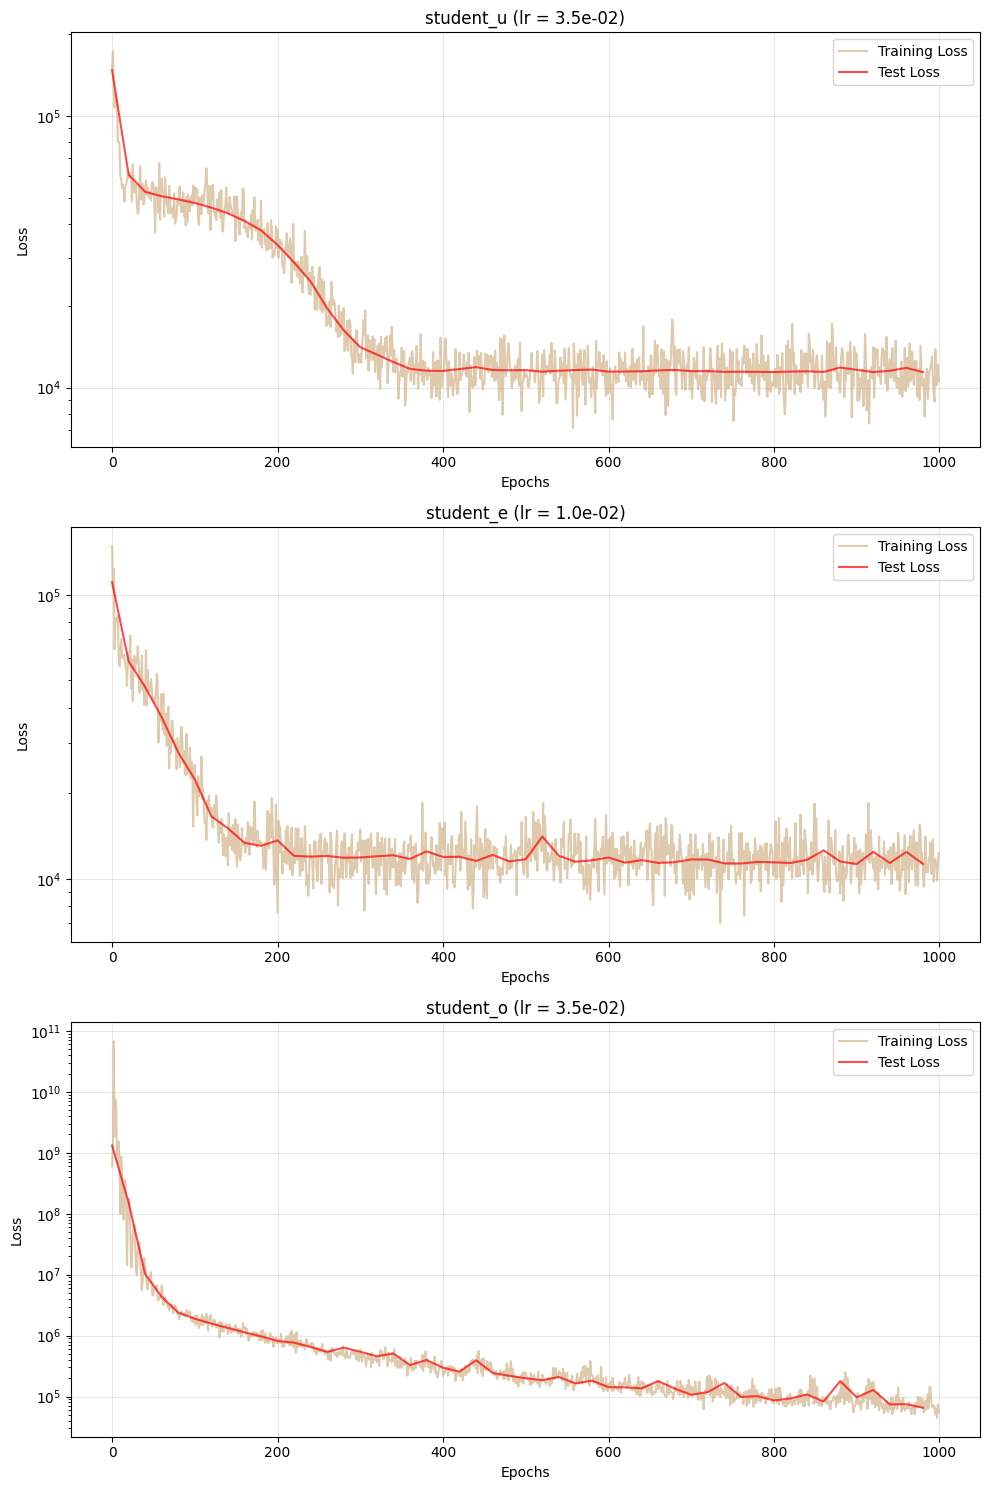

In [73]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
names = list(best_models.keys())

for i, name in enumerate(names):
    ax = axes[i]
    tr = best_models[name]["train_loss"]
    ev = best_models[name]["test_loss"]
    lr = best_models[name]["lr"]

    ax.plot(tr, label="Training Loss", color="tan", alpha=0.7) 
    ax.plot(range(0, len(tr), 20), ev, label="Test Loss", color="red", alpha=0.7)
    ax.set_yscale("log")
    ax.set_title(f"{name} (lr = {lr:.1e})")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

5.   Once the training is over, evaluate the *student* model on the test set one last time. Additionally, collect (separately) weights and biases for each layer of the *student* network, and compare their distribution to that of the *teacher* network. Do the same for the collection of all weights and biases of the network (*i.e.* not on a layer-wise basis).

In [74]:
# Final evaluation loss summary
final_losses = [(k, best_models[k]['test_loss'][-1]) for k in best_models]
print(tabulate(final_losses, headers=["Model", "Final Test Loss"]))

Model        Final Test Loss
---------  -----------------
student_u            11398.5
student_e            11295.1
student_o            65476.9


In [75]:
def extract_weights_and_biases_per_layer(model):
    weights, biases = [], []
    for layer in model.model:
        if isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.cpu().numpy().flatten())
            biases.append(layer.bias.data.cpu().numpy().flatten())
    return weights, biases

# Teacher
teacher_weights, teacher_biases = extract_weights_and_biases_per_layer(teacher)

# Students
student_weights = {}
student_biases = {}

for name, model in students.items():
    w, b = extract_weights_and_biases_per_layer(model)
    student_weights[name] = w
    student_biases[name] = b

In [76]:
def print_model_params_summary(teacher_w, teacher_b, student_ws, student_bs):
    print("\nTeacher")
    print(f"  • Layers: {len(teacher_w)}")
    print(f"  • Total Weights: {sum(len(w) for w in teacher_w)}")
    print(f"  • Total Biases: {sum(len(b) for b in teacher_b)}")
    for i, (w, b) in enumerate(zip(teacher_w, teacher_b)):
        print(f"    Layer {i+1}: Weights = {len(w):>6}, Biases = {len(b):>4}")

    print("\nStudents")
    for name in student_ws:
        print(f"\n {name}")
        print(f"    • Layers: {len(student_ws[name])}")
        print(f"    • Total Weights: {sum(len(w) for w in student_ws[name])}")
        print(f"    • Total Biases: {sum(len(b) for b in student_bs[name])}")
        for i, (w, b) in enumerate(zip(student_ws[name], student_bs[name])):
            print(f"      Layer {i+1}: Weights = {len(w):>6}, Biases = {len(b):>4}")

# Chiamata alla funzione
print_model_params_summary(teacher_weights, teacher_biases, student_weights, student_biases)


Teacher
  • Layers: 4
  • Total Weights: 11760
  • Total Biases: 136
    Layer 1: Weights =   7500, Biases =   75
    Layer 2: Weights =   3750, Biases =   50
    Layer 3: Weights =    500, Biases =   10
    Layer 4: Weights =     10, Biases =    1

Students

 student_u
    • Layers: 2
    • Total Weights: 1010
    • Total Biases: 11
      Layer 1: Weights =   1000, Biases =   10
      Layer 2: Weights =     10, Biases =    1

 student_e
    • Layers: 4
    • Total Weights: 11760
    • Total Biases: 136
      Layer 1: Weights =   7500, Biases =   75
      Layer 2: Weights =   3750, Biases =   50
      Layer 3: Weights =    500, Biases =   10
      Layer 4: Weights =     10, Biases =    1

 student_o
    • Layers: 5
    • Total Weights: 120100
    • Total Biases: 701
      Layer 1: Weights =  20000, Biases =  200
      Layer 2: Weights =  40000, Biases =  200
      Layer 3: Weights =  40000, Biases =  200
      Layer 4: Weights =  20000, Biases =  100
      Layer 5: Weights =    100, B

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

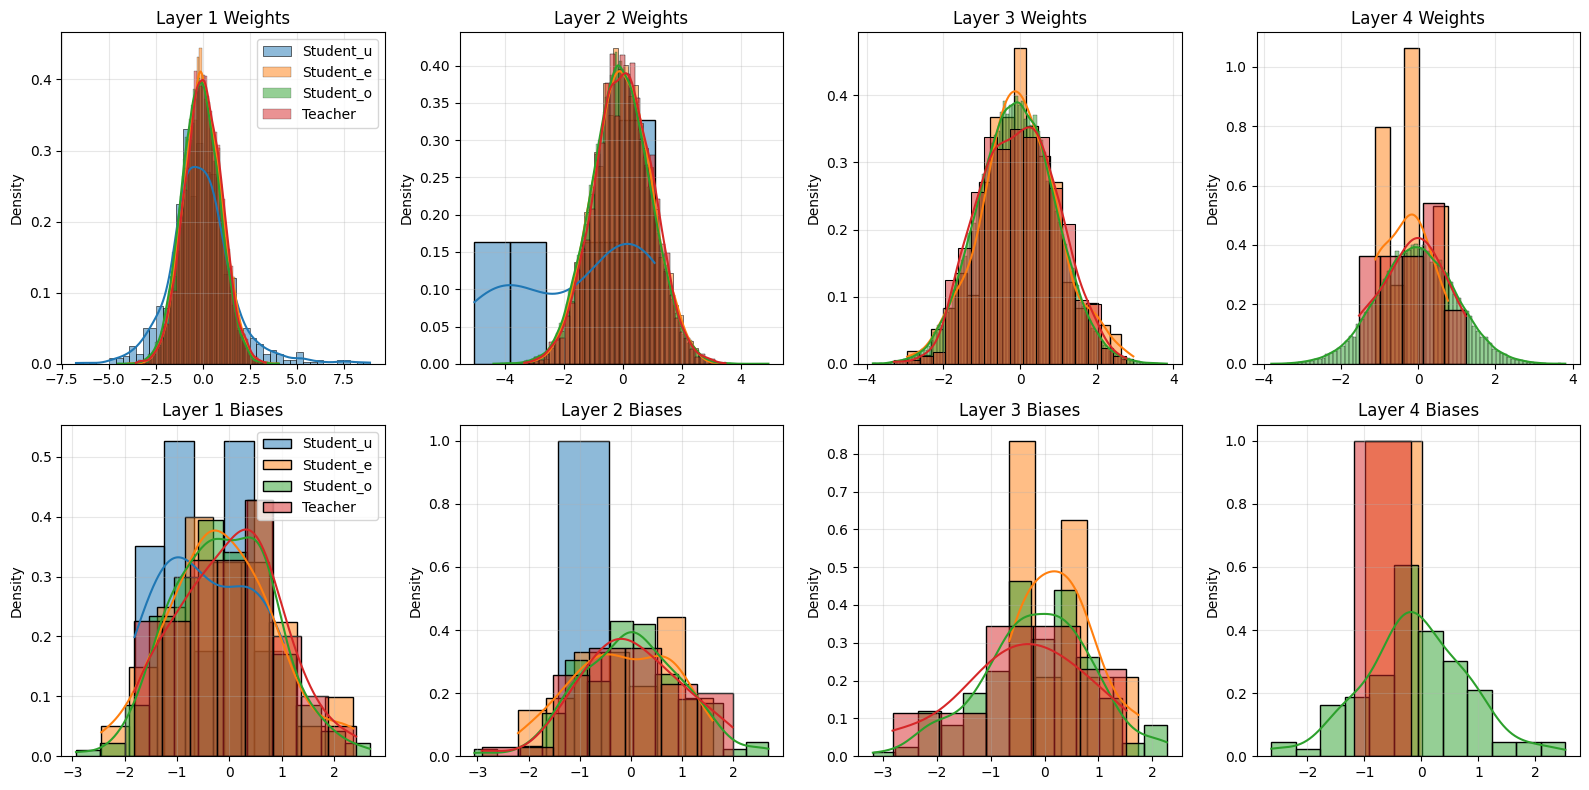

In [77]:
palette = {
    "student_u": "#1f77b4",  # Blue
    "student_e": "#ff7f0e",  # Orange
    "student_o": "#2ca02c",  # Green
    "Teacher": "#d62728",    # Red
}

# Lista dei modelli in ordine per plotting
model_names = ["student_u", "student_e", "student_o", "Teacher"]

# Numero massimo di layer da confrontare
n_layers = len(teacher_weights)

# Numero di subplot: 2 (weights + biases) × n_layers
fig = plt.figure(figsize=(4 * n_layers, 8))

for layer in range(n_layers):
    ax_w = fig.add_subplot(2, n_layers, layer + 1)
    ax_b = fig.add_subplot(2, n_layers, layer + 1 + n_layers)

    # Weights plot
    for name in model_names:
        if name == "Teacher":
            weights = teacher_weights
        elif layer < len(student_weights[name]):
            weights = student_weights[name]
        else:
            continue  # skip if student doesn't have this layer

        sns.histplot(weights[layer], kde=True, ax=ax_w, stat='density',
                     color=palette[name], label=name.capitalize())

    ax_w.set_title(f"Layer {layer+1} Weights")
    ax_w.grid(alpha=0.3)
    if layer == 0:
        ax_w.legend()

    # Biases plot
    for name in model_names:
        if name == "Teacher":
            biases = teacher_biases
        elif layer < len(student_biases[name]):
            biases = student_biases[name]
        else:
            continue  # skip if student doesn't have this layer

        sns.histplot(biases[layer], kde=True, ax=ax_b, stat='density',
                     color=palette[name], label=name.capitalize())

    ax_b.set_title(f"Layer {layer+1} Biases")
    ax_b.grid(alpha=0.3)
    if layer == 0:
        ax_b.legend()

plt.tight_layout()
plt.show()

In [78]:
def flatten_all(weights_list, biases_list):
    all_weights = np.concatenate(weights_list)
    all_biases = np.concatenate(biases_list)
    return all_weights, all_biases

# Teacher
teacher_w_all, teacher_b_all = flatten_all(teacher_weights, teacher_biases)

# Students
student_w_all = {}
student_b_all = {}

for name in student_weights:
    w, b = flatten_all(student_weights[name], student_biases[name])
    student_w_all[name] = w
    student_b_all[name] = b

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

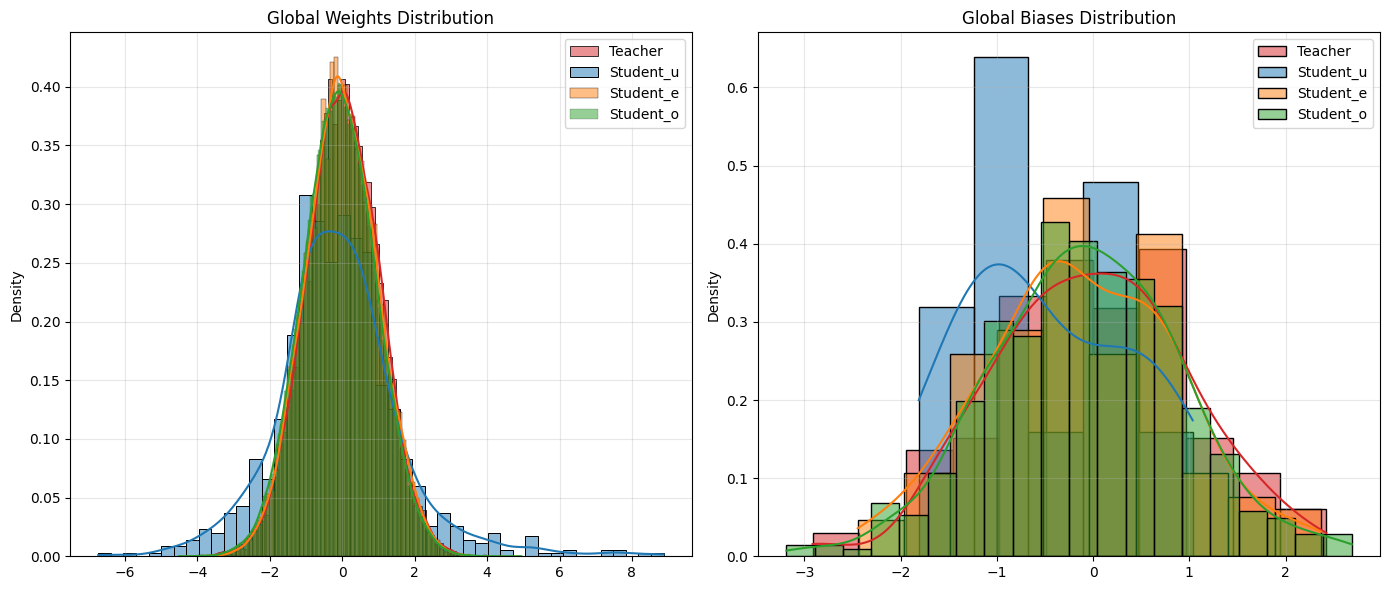

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ====== WEIGHTS ======
sns.histplot(teacher_w_all, kde=True, ax=axs[0], stat='density',
             color=palette["Teacher"], label='Teacher')
for name in student_w_all:
    sns.histplot(student_w_all[name], kde=True, ax=axs[0], stat='density',
                 color=palette[name], label=name.capitalize())

axs[0].set_title("Global Weights Distribution")
axs[0].grid(alpha=0.3)
axs[0].legend()

# ====== BIASES ======
sns.histplot(teacher_b_all, kde=True, ax=axs[1], stat='density',
             color=palette["Teacher"], label='Teacher')
for name in student_b_all:
    sns.histplot(student_b_all[name], kde=True, ax=axs[1], stat='density',
                 color=palette[name], label=name.capitalize())

axs[1].set_title("Global Biases Distribution")
axs[1].grid(alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.show()

Comment on the results collected, specifically in terms of: number of learnable parameters, trainability, generalisation, distributional convergence to target parameters. Do so individually in each case, as well as in comparison across the different *student* models.